# Figure 16: Particle stopping and sorting calculations

Code to calculate a Monte Carlo survey of the maximum size of particle stopped in the nebula shock with variable shock and plume parameters.

## Load modules

In [1]:
%run import-modules-grid

import scipy as sp
import struct
from scipy import constants as const

from scipy.optimize import fsolve

import copy as copy

import csv as csv

import functools as ft
import multiprocess as mp

#plotting packages
import matplotlib as mpl
import pylab
import matplotlib.cm as cm
from matplotlib import gridspec

#import bespoke python scripts
from gradients import *
import colormaps as cmaps

#import the droplet structure
from shearing_droplet_structure import *

print('done')

Platform:  Darwin Kernel Version 24.1.0: Thu Oct 10 21:00:32 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6030
python version:  3.11.10
matplotlib version:  3.9.2
hvplot version:  0.11.0
numpy version:  2.1.2
pandas version:  2.2.3
pickle version:  4.0
yaml version:  6.0.2
pint version:  0.24.3
pyko version:  v0.8.3-dev-2024-05-12
print eos_table version:  v1.1.5b

Number of CPUs in the system: 12


done


## Parameters

In [2]:
#flag as to whether to use the reference data or produce new data
#If false, will rerun monte carlo simulations
flag_ref_data=True

#material flags 
flag_cond=0 #(0 for silicate, 1 for iron)
#Wlotzka 1983 Table 1. Mean Tieshitz chondrules
cond_comp={"SiO2": 43.9,
    "TiO2": 0.0,
    "Al2O3": 7.66,
    "FeO": 4.36,
    "MnO": 0.0,
    "MgO": 37.5,
    "CaO": 2.02,
    "Na2O": 3.39,
    "K2O": 0.,
    "P2O5": 0.,
    "H2O": 0.,
    "F2O-1": 0.0}

#molar fraction of H2 in nebula
flag_vap=0
XH2=0.818
vap_prop=[XH2]
flag_vap2=1

#flag for the form to use for CD
flag_CD_form=1

#prefactor to use in force balance equations
prefac=4.0

#velocity at which to consider the particle stopped
vstop=10.0E0

#initial guess and tollerance for integrations
tguess=100.0
toll=1E-6
toll2=toll/100

#sound speed used for breakup time
cs_breakup=1E3

#number of cores to use for MC
Npro=7
Npro=int(np.amin([Npro, os.cpu_count()-1])) #make sure only the number of available cores (-1) is not exceeded
NMC=500

rho_mono=3E3 #density of agregate monomers
r_mono=1E-6 #size of agregate monomers
Vfrac_ag=0.5 #volume fraction of aggregates

#value ranges for monte carlo
vvap_range=np.asarray([1.,5])*1E3
logrho_vap_range=np.asarray([-9.,-5])
Tvap_range=np.asarray([1000.,2500])

deltav_L_range=np.asarray([0.1,10])*1E6
deltav2_range=np.asarray([1.,10])*1E3

logrho_vap2_range=np.asarray([-9.,-5])
Tvap2_range=np.asarray([400.,2000])

vstop_range=np.asarray([1.,500.])



## Required functions for MC

In [3]:
#find max droplet stopped
def func_calc_rstop(logR,L_to_stop,drop,vstop,tguess,toll,Ncalc,Ncalc_final,flag_CD_form,flag_stab_check):
    # print(logR)
    drop.Rcond=10.**logR   #take the log of the guess  
    drop.init_droplet(drop.flag_cond,drop.Rcond,drop.Tcond,drop.flag_vap,drop.vap_prop,drop.rho_vap,drop.Tvap,\
                       drop.vvap,drop.cs,drop.prefac,\
                       flag_CD_form_dynamic=drop.flag_CD_form_dynamic, flag_CD_self_consistent=drop.flag_CD_self_consistent,
                     Vfrac_ag=drop.Vfrac_ag, rho_mono_ag=drop.rho_mono_ag, r_mono_ag=drop.r_mono_ag)
    drop.find_stopping_time2(vstop,tguess,toll,Ncalc,Ncalc_final,flag_CD_form=drop.flag_CD_form,flag_stab_check=flag_stab_check)
    
    return (drop.Lstop-L_to_stop)/L_to_stop
    
#2 step version
def func_calc_rstop_2step(logR,L_to_stop,drop,vstop,tguess,toll,Ncalc,Ncalc_final,flag_CD_form,flag_stab_check):
    
    drop.Rcond=10.**logR   
    drop.flag_stop_stab=1
    
    drop.init_droplet(drop.flag_cond,drop.Rcond,drop.Tcond,drop.flag_vap,drop.vap_prop,drop.rho_vap,drop.Tvap,\
                       drop.vvap,drop.cs,drop.prefac,\
                       flag_CD_form_dynamic=drop.flag_CD_form_dynamic, flag_CD_self_consistent=drop.flag_CD_self_consistent,\
                  deltav_L=drop.deltav_L,deltav2=drop.deltav2,flag_vap2=drop.flag_vap2,rho_vap2=drop.rho_vap2,Tvap2=drop.Tvap2,\
                    Vfrac_ag=drop.Vfrac_ag, rho_mono_ag=drop.rho_mono_ag, r_mono_ag=drop.r_mono_ag)
    drop.find_stopping_time_2step(vstop,tguess,toll,Ncalc,Ncalc_final,flag_CD_form=drop.flag_CD_form,flag_stab_check=flag_stab_check)

    if (drop.flag_hit_2nd_wave==0):
        return (L_to_stop-drop.Lstop)/L_to_stop
    else:
        return (L_to_stop-drop.deltav_L-drop.Lstop2)/L_to_stop
    
    
    

In [4]:
#function to use for multiple processors to calculate the max radius of droplet stopped in the plume
def temp_func_calc_stopped_size_prof(flag_cond,flag_vap2,vap_prop,prefac,flag_CD_form_dynamic,flag_CD_self_consistent,flag_stab_check,\
                              tguess,toll,\
                              vvap_arr,rho_vap_arr,Tvap_arr,deltav_L_arr, deltav2_arr, rho_vap2_arr, Tvap2_arr, vstop_arr, d_plot_arr,\
                                     MCfile, k):
    #make arrays of initial guesses
    init_guess_arr_logR=np.ones(np.size(d_plot_arr[k,:]))*-5.
    init_guess_arr_tguess=np.ones(np.size(d_plot_arr[k,:]))*tguess
    
    Rcond=1E-6
    Nplot=int(np.size(d_plot_arr[k,:])/2)
    # print('Nplot:', Nplot)
    Rstop=np.ones(2*Nplot)*np.nan
    MFP=np.ones(2)*np.nan
    
    #first find the largest particle stopped in the nebula shock
    test=True
    count=0
    init_guess_logR_neb=np.log10(3*deltav_L_arr[k]*rho_vap_arr[k]/3E3/4) #based on stopping mass
    
    neb_flag_unstable=0 #flag as to whether a particle is stopped in the nebula
    while (test)&(count<10):
        count+=1

        drop_neb=shearing_droplet()
        drop_neb.init_droplet(flag_cond,Rcond,Tvap_arr[k],flag_vap,vap_prop,rho_vap_arr[k],Tvap_arr[k],vvap_arr[k],\
                           np.nan,prefac,flag_CD_form_dynamic=flag_CD_form_dynamic, flag_CD_self_consistent=flag_CD_self_consistent)
        (temp_neb,infodict,ier,msg)=fsolve(func_calc_rstop, np.asarray([init_guess_logR_neb]), \
                                           args=(deltav_L_arr[k],drop_neb,vstop_arr[k],tguess,toll,5,100000,drop_neb.flag_CD_form,flag_stab_check),\
                                           xtol=toll2,full_output=1)
        
        
        if (ier!=1)|(np.abs(func_calc_rstop(temp_neb, deltav_L_arr[k],drop_neb,vstop_arr[k],tguess,toll,5,100000,drop_neb.flag_CD_form,flag_stab_check))>toll):
            init_guess_logR_neb+=3*(np.random.rand(1)-0.5)
        elif drop_neb.flag_stop_stab!=1:
            test=False
            neb_flag_unstable=1

        else:
            test=False
            
            drop_neb.init_droplet(flag_cond,10.**temp_neb,Tvap_arr[k],flag_vap,vap_prop,rho_vap_arr[k],Tvap_arr[k],vvap_arr[k],\
                           np.nan,prefac,flag_CD_form_dynamic=flag_CD_form_dynamic, flag_CD_self_consistent=flag_CD_self_consistent)

            drop_neb.find_stopping_time2(vstop_arr[k],tguess,toll,5,100000,flag_CD_form=drop_neb.flag_CD_form,flag_stab_check=2)


            init_guess_arr_logR[Nplot:]=np.log10(10.**temp_neb+\
                                                 3.*(d_plot_arr[k,Nplot:]-deltav_L_arr[k])*rho_vap2_arr[k]/3E3/4.) #set initial guess to the particle size that gets through the nebula
            init_guess_arr_tguess[Nplot:]=drop_neb.tstop+tguess

    #####
    plume_flag_stable=0 #flag as to whether the particle is stable in the vapor plume
    for i in np.arange(2*Nplot):
        # print('\t',i)
        # print('\t',i, d_plot[i])

        if i<Nplot:
            
            
            if (i>1)&(np.isnan(Rstop[i-1])==False)&(Rstop[i-1]!=0.0):
                init_guess_arr_logR[i]=np.log10(Rstop[i-1]+3.*(d_plot_arr[k,i]-d_plot_arr[k,i-1])*rho_vap_arr[k]/3E3/4.)
                init_guess_arr_tguess[i]=drop3.tstop+tguess
            else:
                init_guess_arr_logR[i]=np.log10(d_plot_arr[k,i]*rho_vap_arr[k]/3E3)
                init_guess_arr_tguess[i]=tguess
            
            test=True
            count=0
            while (test)&(count<10):
                count+=1
                
                #standard setup
                drop3=shearing_droplet()
                drop3.init_droplet(flag_cond,Rcond,Tvap_arr[k],flag_vap,vap_prop,rho_vap_arr[k],Tvap_arr[k],vvap_arr[k],\
                                   np.nan,prefac,flag_CD_form_dynamic=flag_CD_form_dynamic, flag_CD_self_consistent=flag_CD_self_consistent)
                MFP[0]=drop3.MFP
                (temp3,infodict,ier,msg)=fsolve(func_calc_rstop, np.asarray([init_guess_arr_logR[i]]), \
                                                args=(d_plot_arr[k,i],drop3,vstop_arr[k],init_guess_arr_tguess[i],toll,5,100000,drop3.flag_CD_form,flag_stab_check),\
                                                xtol=toll2,full_output=1)

                

                if (ier!=1)|(np.abs(func_calc_rstop(temp3, d_plot_arr[k,i],drop3,vstop_arr[k],tguess,toll,5,100000,drop3.flag_CD_form,flag_stab_check))>toll):
                    Rstop[i]=0.0
                    init_guess_arr_logR[i]+=np.random.rand(1)-0.5
                elif drop3.flag_stop_stab!=1:
                    Rstop[i]=np.nan
                    test=False
                else:
                    Rstop[i]=10.**temp3
                    # print('\t\t',msg,Rstop[i])
                    test=False
                    
                    drop3.init_droplet(flag_cond,10.**temp3,Tvap_arr[k],flag_vap,vap_prop,rho_vap_arr[k],Tvap_arr[k],vvap_arr[k],\
                                       np.nan,prefac,flag_CD_form_dynamic=flag_CD_form_dynamic, flag_CD_self_consistent=flag_CD_self_consistent)
                    drop3.find_stopping_time2(vstop_arr[k],init_guess_arr_tguess[i],toll,5,100000,flag_CD_form=drop3.flag_CD_form,flag_stab_check=2)
                    

        else:
            
            # init_guess_arr_logR[i]=-3.
            if (i>Nplot-1)&(plume_flag_stable==1)&(np.isnan(Rstop[i-1])==False)&(Rstop[i-1]!=0.0):
                init_guess_arr_logR[i]=np.log10(Rstop[i-1]+\
                                                3.*(d_plot_arr[k,i]-d_plot_arr[k,i-1])*rho_vap2_arr[k]/3E3/4.)
                init_guess_arr_tguess[i]=drop3.tstop+tguess
                
                
            
            if (drop_neb.flag_stop_stab!=1):
                Rstop[i]=np.nan
            else:
                   
                #####
                #find out if their are particles stopping in the plume after the nebula
                drop_neb2=shearing_droplet()
                drop_neb2.init_droplet(flag_cond,10.**temp_neb,Tvap2_arr[k],flag_vap2,vap_prop,rho_vap2_arr[k],Tvap2_arr[k],deltav2_arr[k],\
                                   np.nan,prefac,flag_CD_form_dynamic=flag_CD_form_dynamic, flag_CD_self_consistent=flag_CD_self_consistent)
                drop_neb2.find_stopping_time2(vstop_arr[k],10.,toll,5,100000,flag_CD_form=drop_neb2.flag_CD_form,flag_stab_check=2)
                MFP[1]=drop_neb2.MFP
                    
                if (drop_neb.flag_stop_stab!=1)|(drop_neb2.Lstop>d_plot_arr[k,i]-deltav_L_arr[k]+toll)|(drop_neb2.flag_stop_stab!=1):
                    Rstop[i]=np.nan
                else:
                    
                    test=True
                    count=0
                    while (test)&(count<10):
                        count+=1
                        drop3=shearing_droplet()
                        drop3.init_droplet(flag_cond,Rcond,Tvap_arr[k],flag_vap,vap_prop,rho_vap_arr[k],Tvap_arr[k],vvap_arr[k],\
                                           np.nan,prefac,flag_CD_form_dynamic=1, flag_CD_self_consistent=1,\
                                      deltav_L=deltav_L_arr[k],deltav2=deltav2_arr[k],flag_vap2=flag_vap2,rho_vap2=rho_vap2_arr[k],Tvap2=Tvap2_arr[k])
                        (temp,infodict,ier,msg)=fsolve(func_calc_rstop_2step, np.asarray([init_guess_arr_logR[i]]), \
                                                       args=(d_plot_arr[k,i],drop3,vstop_arr[k],tguess,toll,5,100000,drop3.flag_CD_form,flag_stab_check),\
                                                       xtol=toll2,full_output=1)
            
                        if (ier!=1)|(np.abs(func_calc_rstop_2step(temp, d_plot_arr[k,i],drop3,vstop_arr[k],init_guess_arr_tguess[i],toll,5,100000,drop3.flag_CD_form,flag_stab_check))>=toll):
                            Rstop[i]=0.0
                            init_guess_arr_logR[i]+=np.random.rand(1)-0.5
                            if count==10:
                                Rstop[i]=np.nan
                                init_guess_arr_logR[i]=np.log10(10.**temp_neb+\
                                                                       3*(d_plot_arr[k,i]-d_plot_arr[k,i-1])*rho_vap2_arr[k]/3E3/4)
                                
                        elif drop3.flag_stop_stab!=1:
                            Rstop[i]=np.nan
                            test=False
                        
                        else:
                            Rstop[i]=10.**temp
                            test=False
                            plume_flag_stable=1
                            
                            
                            drop3.init_droplet(flag_cond,10.**temp,Tvap_arr[k],flag_vap,vap_prop,rho_vap_arr[k],Tvap_arr[k],vvap_arr[k],\
                                               np.nan,prefac,flag_CD_form_dynamic=1, flag_CD_self_consistent=1,\
                                          deltav_L=deltav_L_arr[k],deltav2=deltav2_arr[k],flag_vap2=flag_vap2,rho_vap2=rho_vap2_arr[k],Tvap2=Tvap2_arr[k])
                            drop3.find_stopping_time_2step(vstop_arr[k],init_guess_arr_tguess[i],toll,5,100000,flag_CD_form=drop3.flag_CD_form,flag_stab_check=2)


    f=csv.writer(MCfile,delimiter=',')
    f.writerow(np.concatenate(([vvap_arr[k]],[rho_vap_arr[k]],[Tvap_arr[k]],[deltav_L_arr[k]],\
                               [deltav2_arr[k]],[rho_vap2_arr[k]], [Tvap2_arr[k]],[vstop_arr[k]],\
                [Nplot],d_plot_arr[k,:],Rstop,MFP)))
            
    print('done '+str(k)+'\n')
    return Rstop, MFP

In [5]:
#as above but for aggregates
def temp_func_calc_stopped_ag_size_prof(flag_cond,flag_vap2,vap_prop,prefac,flag_CD_form_dynamic,flag_CD_self_consistent,flag_stab_check,\
                                     Vfrac_ag, rho_mono, r_mono_ag,
                              tguess,toll,\
                              vvap_arr,rho_vap_arr,Tvap_arr,deltav_L_arr, deltav2_arr, rho_vap2_arr, Tvap2_arr, vstop_arr, d_plot_arr,\
                                     MCfile, k):
    
    print(k)
  
    init_guess_arr_logR=np.ones(np.size(d_plot_arr[k,:]))*-5.
    init_guess_arr_tguess=np.ones(np.size(d_plot_arr[k,:]))*tguess
    
    Rcond=1E-6
    Nplot=int(np.size(d_plot_arr[k,:])/2)
    Rstop=np.ones(2*Nplot)*np.nan
    MFP=np.ones(2)*np.nan
    
    test=True
    count=0
    init_guess_logR_neb=np.log10(3*deltav_L_arr[k]*rho_vap_arr[k]/(rho_mono*Vfrac_ag)/4) #based on stopping mass
    
    neb_flag_unstable=0
    while (test)&(count<10):
        count+=1

        drop_neb=shearing_droplet()
        drop_neb.init_droplet(flag_cond,Rcond,Tvap_arr[k],flag_vap,vap_prop,rho_vap_arr[k],Tvap_arr[k],vvap_arr[k],\
                           np.nan,prefac,flag_CD_form_dynamic=flag_CD_form_dynamic, flag_CD_self_consistent=flag_CD_self_consistent,\
                             Vfrac_ag=Vfrac_ag, rho_mono_ag=rho_mono, r_mono_ag=r_mono)
        (temp_neb,infodict,ier,msg)=fsolve(func_calc_rstop, np.asarray([init_guess_logR_neb]), \
                                           args=(deltav_L_arr[k],drop_neb,vstop_arr[k],tguess,toll,5,1000,drop_neb.flag_CD_form,flag_stab_check),\
                                           xtol=toll2,full_output=1)
        
        
        
        if (ier!=1)|(np.abs(func_calc_rstop(temp_neb, deltav_L_arr[k],drop_neb,vstop_arr[k],tguess,toll,5,100000,drop_neb.flag_CD_form,flag_stab_check))>toll):
            init_guess_logR_neb+=3*(np.random.rand(1)-0.5)
        elif drop_neb.flag_stop_stab!=1:
            neb_flag_stable=1
            test=False
        else:
            test=False
            
            drop_neb.init_droplet(flag_cond,10.**temp_neb,Tvap_arr[k],flag_vap,vap_prop,rho_vap_arr[k],Tvap_arr[k],vvap_arr[k],\
                           np.nan,prefac,flag_CD_form_dynamic=flag_CD_form_dynamic, flag_CD_self_consistent=flag_CD_self_consistent,\
                                 Vfrac_ag=Vfrac_ag, rho_mono_ag=rho_mono, r_mono_ag=r_mono)

            drop_neb.find_stopping_time2(vstop_arr[k],tguess,toll,5,100000,flag_CD_form=drop_neb.flag_CD_form,flag_stab_check=2)

            init_guess_arr_logR[Nplot:]=np.log10(10.**temp_neb+\
                                                 3.*(d_plot_arr[k,Nplot:]-deltav_L_arr[k])*rho_vap2_arr[k]/(rho_mono*Vfrac_ag)/4.) #set initial guess to the particle size that gets through the nebula
            init_guess_arr_tguess[Nplot:]=drop_neb.tstop+tguess
    
    #####
    plume_flag_stable=0
    for i in np.arange(2*Nplot):

        if i<Nplot:
            
            
            if (i>1)&(np.isnan(Rstop[i-1])==False)&(Rstop[i-1]!=0.0):
                init_guess_arr_logR[i]=np.log10(Rstop[i-1]+3.*(d_plot_arr[k,i]-d_plot_arr[k,i-1])*rho_vap_arr[k]/(rho_mono*Vfrac_ag)/4.)
                init_guess_arr_tguess[i]=drop3.tstop+tguess
            else:
                init_guess_arr_logR[i]=np.log10(d_plot_arr[k,i]*rho_vap_arr[k]/(rho_mono*Vfrac_ag))
                init_guess_arr_tguess[i]=tguess
                
            
            test=True
            count=0
            while (test)&(count<10):
                count+=1
                
                #standard setup
                drop3=shearing_droplet()
                drop3.init_droplet(flag_cond,Rcond,Tvap_arr[k],flag_vap,vap_prop,rho_vap_arr[k],Tvap_arr[k],vvap_arr[k],\
                                   np.nan,prefac,flag_CD_form_dynamic=flag_CD_form_dynamic, flag_CD_self_consistent=flag_CD_self_consistent,\
                                  Vfrac_ag=Vfrac_ag, rho_mono_ag=rho_mono, r_mono_ag=r_mono)
                MFP[0]=drop3.MFP
                (temp3,infodict,ier,msg)=fsolve(func_calc_rstop, np.asarray([init_guess_arr_logR[i]]), \
                                                args=(d_plot_arr[k,i],drop3,vstop_arr[k],init_guess_arr_tguess[i],toll,5,1000,drop3.flag_CD_form,flag_stab_check),\
                                                xtol=toll2,full_output=1)

                
                
                if (ier!=1)|(np.abs(func_calc_rstop(temp3, d_plot_arr[k,i],drop3,vstop_arr[k],tguess,toll,5,100000,drop3.flag_CD_form,flag_stab_check))>toll):
                    Rstop[i]=0.0
                    init_guess_arr_logR[i]+=np.random.rand(1)-0.5

                elif drop3.flag_stop_stab!=1:
                    Rstop[i]=np.nan
                    test=False

                else:
                    Rstop[i]=10.**temp3
                    test=False
                    
                    drop3.init_droplet(flag_cond,10.**temp3,Tvap_arr[k],flag_vap,vap_prop,rho_vap_arr[k],Tvap_arr[k],vvap_arr[k],\
                                       np.nan,prefac,flag_CD_form_dynamic=flag_CD_form_dynamic, flag_CD_self_consistent=flag_CD_self_consistent,\
                                      Vfrac_ag=Vfrac_ag, rho_mono_ag=rho_mono, r_mono_ag=r_mono)
                    drop3.find_stopping_time2(vstop_arr[k],init_guess_arr_tguess[i],toll,5,100000,flag_CD_form=drop3.flag_CD_form,flag_stab_check=2)
                    
                    
        else:

            if (i>Nplot-1)&(plume_flag_stable==1)&(np.isnan(Rstop[i-1])==False)&(Rstop[i-1]!=0.0):
                init_guess_arr_logR[i]=np.log10(Rstop[i-1]+\
                                                3.*(d_plot_arr[k,i]-d_plot_arr[k,i-1])*rho_vap2_arr[k]/(rho_mono*Vfrac_ag)/4.)
                init_guess_arr_tguess[i]=drop3.tstop+tguess



            if (drop_neb.flag_stop_stab!=1):
                Rstop[i]=np.nan
            else:
  
                #####
                #find out if their are particles stopping in the plume after the nebula
                drop_neb2=shearing_droplet()
                drop_neb2.init_droplet(flag_cond,10.**temp_neb,Tvap2_arr[k],flag_vap2,vap_prop,rho_vap2_arr[k],Tvap2_arr[k],deltav2_arr[k],\
                                   np.nan,prefac,flag_CD_form_dynamic=flag_CD_form_dynamic, flag_CD_self_consistent=flag_CD_self_consistent,\
                                       Vfrac_ag=Vfrac_ag, rho_mono_ag=rho_mono, r_mono_ag=r_mono)
                drop_neb2.find_stopping_time2(vstop_arr[k],10.,toll,5,100000,flag_CD_form=drop_neb2.flag_CD_form,flag_stab_check=2)
                MFP[1]=drop_neb2.MFP

                if (drop_neb.flag_stop_stab!=1)|(drop_neb2.Lstop>d_plot_arr[k,i]-deltav_L_arr[k]+toll)|(drop_neb2.flag_stop_stab!=1):
                    Rstop[i]=np.nan
                else:

                    test=True
                    count=0
                    while (test)&(count<10):
                        count+=1
                        #standard setup
                        drop3=shearing_droplet()
                        drop3.init_droplet(flag_cond,Rcond,Tvap_arr[k],flag_vap,vap_prop,rho_vap_arr[k],Tvap_arr[k],vvap_arr[k],\
                                           np.nan,prefac,flag_CD_form_dynamic=1, flag_CD_self_consistent=1,\
                                      deltav_L=deltav_L_arr[k],deltav2=deltav2_arr[k],flag_vap2=flag_vap2,rho_vap2=rho_vap2_arr[k],Tvap2=Tvap2_arr[k],\
                                           Vfrac_ag=Vfrac_ag, rho_mono_ag=rho_mono, r_mono_ag=r_mono)
                        (temp,infodict,ier,msg)=fsolve(func_calc_rstop_2step, np.asarray([init_guess_arr_logR[i]]), \
                                                       args=(d_plot_arr[k,i],drop3,vstop_arr[k],tguess,toll,5,100000,drop3.flag_CD_form,flag_stab_check),\
                                                       xtol=toll2,full_output=1)

                        if (ier!=1)|(np.abs(func_calc_rstop_2step(temp, d_plot_arr[k,i],drop3,vstop_arr[k],init_guess_arr_tguess[i],toll,5,100000,drop3.flag_CD_form,flag_stab_check))>=toll):
                            Rstop[i]=0.0
                            init_guess_arr_logR[i]+=np.random.rand(1)-0.5
                            if count==10:
                                Rstop[i]=np.nan
                                
                        elif drop3.flag_stop_stab!=1:
                            Rstop[i]=np.nan
                            test=False

                        else:
                            Rstop[i]=10.**temp
                            test=False
                            plume_flag_stable=1


                            drop3.init_droplet(flag_cond,10.**temp,Tvap_arr[k],flag_vap,vap_prop,rho_vap_arr[k],Tvap_arr[k],vvap_arr[k],\
                                               np.nan,prefac,flag_CD_form_dynamic=1, flag_CD_self_consistent=1,\
                                          deltav_L=deltav_L_arr[k],deltav2=deltav2_arr[k],flag_vap2=flag_vap2,rho_vap2=rho_vap2_arr[k],Tvap2=Tvap2_arr[k],\
                                               Vfrac_ag=Vfrac_ag, rho_mono_ag=rho_mono, r_mono_ag=r_mono)
                            drop3.find_stopping_time_2step(vstop_arr[k],init_guess_arr_tguess[i],toll,5,100000,flag_CD_form=drop3.flag_CD_form,flag_stab_check=2)

    
    f=csv.writer(MCfile,delimiter=',')
    f.writerow(np.concatenate(([vvap_arr[k]],[rho_vap_arr[k]],[Tvap_arr[k]],[deltav_L_arr[k]],\
                               [deltav2_arr[k]],[rho_vap2_arr[k]], [Tvap2_arr[k]],[vstop_arr[k]],\
                [Nplot],d_plot_arr[k,:],Rstop,MFP)))
            
    print('done '+str(k)+'\n')
    return Rstop, MFP

## If desired re-conduct an MC survey

In [6]:
if flag_ref_data==False:
    #MC for exploreing the range of parameter space

    np.random.seed(2)
    
    Nplot=20
    MCfile_name='data/MC_results_drops.csv'
    
    if os.path.exists(MCfile_name):
        print('fish')
        MCfile=open(MCfile_name, "a")
    
        f=csv.writer(MCfile,delimiter=',')
        f.writerow('')
    else:
        print('camera')
        MCfile=open(MCfile_name, "a")
    
        f=csv.writer(MCfile,delimiter=',')
        f.writerow(['vvap', 'rho_vap', 'Tvap', 'deltav_L', 'deltav2', 'rho_vap2', 'Tvap2', 'vstop', 'Nplot', 'd_plot', \
                    ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', \
                    'Rstop', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',' ' , ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',' ' , ' ', ' ', ' ', ' ', 'MFP'])
    
    RstopMC=np.ones((NMC,2*Nplot))*np.nan
    
    MFP_MC=np.ones((NMC,2))*np.nan
    
    #make the randomly sampled arrays
    temp=np.random.rand(8*NMC)
    vvap_MC=vvap_range[0]+temp[0:NMC]*(vvap_range[1]-vvap_range[0])
    rho_vap_MC=10**(logrho_vap_range[0]+temp[NMC:2*NMC]*(logrho_vap_range[1]-logrho_vap_range[0]))
    Tvap_MC=Tvap_range[0]+temp[2*NMC:3*NMC]*(Tvap_range[1]-Tvap_range[0])
    
    deltav_L_MC=deltav_L_range[0]+temp[3*NMC:4*NMC]*(deltav_L_range[1]-deltav_L_range[0])
    deltav2_MC=deltav2_range[0]+temp[4*NMC:5*NMC]*(deltav2_range[1]-deltav2_range[0])
    
    rho_vap2_MC=10**(logrho_vap2_range[0]+temp[5*NMC:6*NMC]*(logrho_vap2_range[1]-logrho_vap2_range[0]))
    Tvap2_MC=Tvap2_range[0]+temp[6*NMC:7*NMC]*(Tvap2_range[1]-Tvap2_range[0])
    
    vstop_MC=vstop_range[0]+temp[7*NMC:8*NMC]*(vstop_range[1]-vstop_range[0])
    
    d_plotMC=np.ones((NMC,2*Nplot))*np.nan
    for ii in np.arange(NMC):
        d_plot=np.append(np.linspace(deltav_L_MC[ii]/1000.,deltav_L_MC[ii],Nplot),np.linspace(deltav_L_MC[ii]*1.001,2*deltav_L_MC[ii],Nplot))
        d_plotMC[ii,:]=d_plot
        
    #reseed for pertubations
    np.random.seed(1)
     
    # pool.close
    start=time.time()
    
    #set up a pool of workers to do parallel computation
    pool = mp.Pool(processes=Npro)
    
    #calculate the stopping sizes
    temp_func=ft.partial(temp_func_calc_stopped_size_prof,flag_cond,flag_vap2,vap_prop,prefac,1,1,2,\
                                  tguess,toll2,\
                                  vvap_MC,rho_vap_MC,Tvap_MC,deltav_L_MC, deltav2_MC, rho_vap2_MC, Tvap2_MC, vstop_MC, d_plotMC,MCfile)
    temp=pool.map( temp_func, np.arange(NMC))
    
    # (flag_cond,flag_vap2,vap_prop,prefac,flag_CD_form_dynamic,flag_CD_self_consistent,flag_stab_check,\
    #                               tguess,toll,\
    #                               vvap_arr,rho_vap_arr,Tvap_arr,deltav_L_arr, deltav2_arr, rho_vap2_arr, Tvap2_arr, vstop_arr, d_plot_arrk):
    
    
    for ii in np.arange(NMC):
        RstopMC[ii,:]=temp[ii][0]
        MFP_MC[ii,:]=temp[ii][1]
        
    
    MCfile.close()       
            
    pool.close()
    print('done')




In [7]:
if flag_ref_data==False:
    #dust bunnies
    np.random.seed(2)
    
    Nplot=20
    
    MCfile_name='data/MC_results_ag.csv'
    
    if os.path.exists(MCfile_name):
        MCfile=open(MCfile_name, "a")
    
        f=csv.writer(MCfile,delimiter=',')
        f.writerow('')
    else:
        
        MCfile=open(MCfile_name, "a")
    
        f=csv.writer(MCfile,delimiter=',')
        f.writerow(['vvap', 'rho_vap', 'Tvap', 'deltav_L', 'deltav2', 'rho_vap2', 'Tvap2', 'vstop', 'Nplot', 'd_plot', \
                    ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', \
                    'Rstop', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',' ' , ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',' ' , ' ', ' ', ' ', ' ', 'MFP'])
    
        
    
    RstopMC_ag=np.ones((NMC,2*Nplot))*np.nan
    MFP_MC=np.ones((NMC,2))*np.nan
    
        
    #reseed for pertubations
    np.random.seed(1)
                    
    # pool.close
    start=time.time()
    
    #set up a pool of workers to do parallel computation
    pool = mp.Pool(processes=Npro)
    
    #calculate the stopping sizes
    temp_func=ft.partial(temp_func_calc_stopped_ag_size_prof,flag_cond,flag_vap2,vap_prop,prefac,1,1,2,\
                         Vfrac_ag, rho_mono, r_mono,
                                  tguess,toll2,\
                                  vvap_MC,rho_vap_MC,Tvap_MC,deltav_L_MC, deltav2_MC, rho_vap2_MC, Tvap2_MC, vstop_MC, d_plotMC, MCfile)
    temp=pool.map( temp_func, np.arange(NMC))
    
    
    for ii in np.arange(NMC):
        RstopMC_ag[ii,:]=temp[ii][0]
        MFP_MC[ii,:]=temp[ii][1]
        
            
    MCfile.close() 
        
        
    pool.close()
            
    print('done')
    


## Read in the existing data

In [8]:
#read in the droplet data
if flag_ref_data:
    MCfile_name='data/MC_results_drops_ref.csv'
else:
    MCfile_name='data/MC_results_drops.csv'
df = pd.read_csv(MCfile_name)

NMC=np.size(df.vvap)
vvap_MC=np.ones(NMC)*np.nan
rho_vap_MC=np.ones(NMC)*np.nan
Tvap_MC=np.ones(NMC)*np.nan
deltav_L_MC=np.ones(NMC)*np.nan
deltav2_MC=np.ones(NMC)*np.nan
rho_vap2_MC=np.ones(NMC)*np.nan
Tvap2_MC=np.ones(NMC)*np.nan
vstop_MC=np.ones(NMC)*np.nan
Nplot_MC=np.zeros(NMC,dtype=int)
d_plotMC=np.ones((NMC,int(2*np.max(df.Nplot))))*np.nan
RstopMC=np.ones((NMC,int(2*np.max(df.Nplot))))*np.nan
MFP_MC=np.ones((NMC,2))*np.nan

#now read in the full lines
MCfile=open(MCfile_name, "r")
csv_reader = csv.reader(MCfile, delimiter=',')
line_count = 0
for row in csv_reader:
    if line_count == 0:
        print(f'Column names are {", ".join(row)}')
        line_count += 1
    else:
        i=line_count-1
        vvap_MC[line_count-1]=row[0]
        rho_vap_MC[line_count-1]=row[1]
        Tvap_MC[line_count-1]=row[2]
        deltav_L_MC[line_count-1]=row[3]
        deltav2_MC[line_count-1]=row[4]
        rho_vap2_MC[line_count-1]=row[5]
        Tvap2_MC[line_count-1]=row[6]
        vstop_MC[line_count-1]=row[7]
        # print(line_count,row[8],int(float(row[8])))
        Nplot_MC[line_count-1]=int(float(row[8]))
        d_plotMC[line_count-1,0:(2*Nplot_MC[i])]=row[9:(9+2*Nplot_MC[i])]
        RstopMC[line_count-1,0:(2*Nplot_MC[i])]=row[(9+2*Nplot_MC[i]):(9+4*Nplot_MC[i])]
        MFP_MC[line_count-1,:]=row[(9+4*Nplot_MC[i])]

        line_count += 1
        
MCfile.close()

# print(vvap_MC)

print('done')


Column names are vvap, rho_vap, Tvap, deltav_L, deltav2, rho_vap2, Tvap2, vstop, Nplot, d_plot, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , Rstop, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , MFP, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , 
done


In [9]:
#read in the aggregate data
if flag_ref_data:
    MCfile_name='data/MC_results_ag_ref.csv'
else:
    MCfile_name='data/MC_results_ag.csv'

df = pd.read_csv(MCfile_name)

NMC_ag=np.size(df.vvap)
vvap_MC_ag=np.ones(NMC_ag)*np.nan
rho_vap_MC_ag=np.ones(NMC_ag)*np.nan
Tvap_MC_ag=np.ones(NMC_ag)*np.nan
deltav_L_MC_ag=np.ones(NMC_ag)*np.nan
deltav2_MC_ag=np.ones(NMC_ag)*np.nan
rho_vap2_MC_ag=np.ones(NMC_ag)*np.nan
Tvap2_MC_ag=np.ones(NMC_ag)*np.nan
vstop_MC_ag=np.ones(NMC_ag)*np.nan
Nplot_MC_ag=np.zeros(NMC_ag,dtype=int)
d_plotMC_ag=np.ones((NMC_ag,int(2*np.max(df.Nplot))))*np.nan
RstopMC_ag=np.ones((NMC_ag,int(2*np.max(df.Nplot))))*np.nan
MFP_MC_ag=np.ones((NMC_ag,2))*np.nan

#now read in the full lines
MCfile=open(MCfile_name, "r")
csv_reader = csv.reader(MCfile, delimiter=',')
line_count = 0
for row in csv_reader:
    if line_count == 0:
        print(f'Column names are {", ".join(row)}')
        line_count += 1
    else:
        i=line_count-1
        vvap_MC_ag[line_count-1]=row[0]
        rho_vap_MC_ag[line_count-1]=row[1]
        Tvap_MC_ag[line_count-1]=row[2]
        deltav_L_MC_ag[line_count-1]=row[3]
        deltav2_MC_ag[line_count-1]=row[4]
        rho_vap2_MC_ag[line_count-1]=row[5]
        Tvap2_MC_ag[line_count-1]=row[6]
        vstop_MC_ag[line_count-1]=row[7]
        # print(line_count,row[8],int(float(row[8])))
        Nplot_MC_ag[line_count-1]=int(float(row[8]))
        d_plotMC_ag[line_count-1,0:(2*Nplot_MC[i])]=row[9:(9+2*Nplot_MC[i])]
        RstopMC_ag[line_count-1,0:(2*Nplot_MC[i])]=row[(9+2*Nplot_MC[i]):(9+4*Nplot_MC[i])]
        MFP_MC_ag[line_count-1,:]=row[(9+4*Nplot_MC[i])]

        line_count += 1
        
MCfile.close()

# print(vvap_MC)

print('done')


Column names are vvap, rho_vap, Tvap, deltav_L, deltav2, rho_vap2, Tvap2, vstop, Nplot, d_plot, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , Rstop, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , MFP, 
done


## Stopped diameter as a function of nebula pressure

done


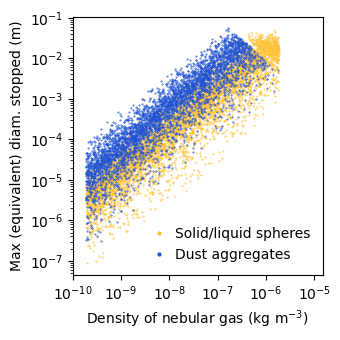

In [10]:
#####initialize the figure

#now the real plot
Ncol=1
Nrow=1
fig = plt.figure(figsize=(3.5,3.5))                                                                                                       
# fig = plt.figure(figsize=(7.32, 9.55))
gs = gridspec.GridSpec(Nrow, Ncol#,
                       #width_ratios=[1,1]
)

ax = [[plt.subplot(gs[0])]]

font = {
        'weight' : 'normal',
        'size'   : 10}


# mpl.rc('text.latex', preamble=r'\usepackage{cmbright}')
# mpl.rcParams['text.usetex'] = True
mpl.rc('text',usetex=False)
mpl.rc('font', **font)

col=cmaps.parula([0.85,0.1])
    
#strong shock density factor
gamma_ss=1.41*XH2+1.66*(1-XH2)
rho_fac_ss=(gamma_ss+1)/(gamma_ss-1)

    
ind_plot=np.where(np.isnan(RstopMC[:,Nplot_MC[0]-1])==False)[0]
# ind_plot=np.where((np.isnan(RstopMC[:,Nplot_MC[0]-1])==False)&(RstopMC[:,Nplot_MC[0]-1]<Rmax))[0]

ind_plot_ag=np.where(np.isnan(RstopMC_ag[:,Nplot_MC_ag[0]-1])==False)[0]

marker_size=0.8
ax[0][0].plot(rho_vap_MC[ind_plot]/rho_fac_ss,RstopMC[ind_plot,Nplot_MC[0]-1]*2,'.',color=col[0],markersize=marker_size,label='Solid/liquid spheres')
ax[0][0].plot(rho_vap_MC_ag[ind_plot_ag]/rho_fac_ss,RstopMC_ag[ind_plot_ag,Nplot_MC_ag[0]-1]*2*(Vfrac_ag**(1./3)),'.',color=col[1],markersize=marker_size, label='Dust aggregates')

ax[0][0].legend(frameon=False,markerscale=5,handletextpad=0.1)

ax[0][0].set_xlabel('Density of nebular gas (kg m$^{-3}$)')
    
ax[0][0].set_ylabel('Max (equivalent) diam. stopped (m)')

ax[0][0].set_yscale('log')
ax[0][0].set_xscale('log')

ax[0][0].set_xlim([1E-10,1.5E-5])
ax[0][0].set_xticks(10.**np.arange(-10,-4))
    
    
fig.tight_layout()
plt.savefig('plots/Fig16-stopped_size_vs_density.pdf')

print('done')